In [1]:

import torch
import torchvision
from torch import nn 
#from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import random
import dataset_utils
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)

In [3]:

batch_size = 1000 
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_val, X_test, y_train_val, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
print(y_test)
train_data = X_train_val
train_data['species_name'] = y_train_val

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)
'''from torch.utils.data import Dataset, DataLoader
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=2000,shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=False, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)'''

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object


'from torch.utils.data import Dataset, DataLoader\n \nclass WholeDataset(Dataset):\n    def __init__(self, data, transform=None):\n        self.data = data\n        self.targets = data.targets#torch.tensor(targets)\n        #self.transform = transform\n        \n    def __getitem__(self, index):\n        x = self.data[index][0]\n        y = self.targets[index]\n        \n        return x, y\n    \n    def __len__(self):\n        return len(self.data)\n        \nwhole_dataset = WholeDataset(image_dataset)\nn_classes = np.unique(whole_dataset.targets).shape[0]\nprint(len(test_indices+val_indices+train_indices))\nlen(whole_dataset)\n\ntrain_imgs = torch.utils.data.Subset(whole_dataset, train_indices)\nval_imgs = torch.utils.data.Subset(whole_dataset, val_indices)\ntest_imgs = torch.utils.data.Subset(whole_dataset, test_indices)\nlen(train_imgs)+len(val_imgs)+len(test_imgs)\ntrain_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=False, num_workers=2)\nval_load

In [4]:
train_labels = np.array(image_dataset.imgs)[train_indices][:,1].astype(int)
val_labels = np.array(image_dataset.imgs)[val_indices][:,1].astype(int)

In [5]:
val_labels

array([   1,    1,    2, ..., 1049, 1049, 1049])

In [6]:

y_train = y_train.apply(lambda x: image_dataset.class_to_idx[x.replace(' ','_')])
y_test = y_test.apply(lambda x: image_dataset.class_to_idx[x.replace(' ','_')])
y_validation= y_validation.apply(lambda x: image_dataset.class_to_idx[x.replace(' ','_')])
y_train_val = y_train_val.apply(lambda x: image_dataset.class_to_idx[x.replace(' ','_')])

In [7]:
###ROBA NUOVA AAA
n_described_val = 0
n_undescribed_val = 0
for vv in np.unique(y_validation):
    if vv in np.unique(y_train):
        n_described_val +=1
    else:
        n_undescribed_val +=1

print(n_described_val)
print(n_undescribed_val)
n_described_test = 0
n_undescribed_test = 0
for vv in np.unique(y_test):
    if vv in np.unique(y_train_val):
        n_described_test +=1
    else:
        n_undescribed_test +=1

print(n_described_test)
print(n_undescribed_test)

650
132
797
215


In [8]:
class DNAdataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = torch.tensor(np.float32(self.data[index][0])).unsqueeze(0)
        y = self.targets[index]
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
d_train = DNAdataset(X_train.values, y_train.values)
d_val = DNAdataset(X_validation.values, y_validation.values)
d_test = DNAdataset(X_test.values, y_test.values)

In [9]:
dataloader_train = DataLoader(d_train, batch_size=32,shuffle=True)
dataloader_val = DataLoader(d_val, batch_size=32,shuffle=True)
dataloaders = {'train':dataloader_train,'val':dataloader_val}
dataset_sizes = {'train': d_train.data.shape[0], 'val':d_val.data.shape[0]}

In [10]:

from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        for dnas,labels in tqdm(dataloaders['train']):
            model.train()
            dnas = dnas.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            predicted_labels = model(dnas)
            train_loss = criterion(predicted_labels,labels)
            train_loss.backward()
            optimizer.step()
            
            _, preds = torch.max(predicted_labels, 1)
            #print(preds)
            #print(labels.data)
            running_train_corrects += torch.sum(preds == labels.data)
        train_losses.append(train_loss)
        
        running_val_corrects = 0
        for dnas,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                dnas = dnas.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                predicted_labels = model(dnas)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                #print(preds)
                #print(labels.data)
                running_val_corrects += torch.sum(preds == labels.data)
        val_losses.append(val_loss)
        
        
        
        #real_scores.append(real_score)
        #fit_p.writer.add_scalar('loss_g', loss_g, epoch)
        # Log losses & scores (last batch)
        
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc))
        #print(f"class accuracy real {class_accuracy_real}")
    
    return train_losses

In [11]:
class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        #self.linear1 = torch.nn.Linear(658, 200)
        self.conv1 = torch.nn.Conv2d(1,8,(5,1))
        self.activation1 = torch.nn.LeakyReLU()
        self.norm1 = torch.nn.BatchNorm2d(8)
        self.conv2 = torch.nn.Conv2d(8,1,(5,1))
        self.activation2 = torch.nn.LeakyReLU()
        self.norm2 = torch.nn.BatchNorm2d(1)
        #self.conv2 = torch.nn.Conv2d(2, 2,1)
        #self.conv2 = torch.nn.Conv2d(5,1,(3,1))
        #self.activation2 = torch.nn.LeakyReLU()
        #self.norm2 = torch.nn.BatchNorm2d(1)
        self.flat = torch.nn.Flatten()
        self.linear = torch.nn.Linear(3250,1500)
        self.dropout1= torch.nn.Dropout(0.70)
        self.dropout2= torch.nn.Dropout(0.70)
        self.activation3 = torch.nn.LeakyReLU()
        self.linear2 = torch.nn.Linear(1500,1050)
        #self.softmax = torch.nn.Softmax()
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.norm2(x)
        x = self.dropout1(x)
        #x = self.conv2(x)
        #x = self.activation2(x)
        #x = self.norm2(x)
        x = self.flat(x)
        x = self.linear(x)
        x = self.dropout2(x)
        x = self.activation3(x)
        x = self.linear2(x)
        #x = self.softmax(x)
        return x
    def feature_extract(self,x):
        print(x.shape)

        x = self.conv1(x)
        x = self.activation1(x)
        x = self.norm1(x)
        x = self.conv2(x)
        #x = self.activation2(x)
        #x = self.norm2(x)

        x = self.flat(x)
        #x = self.linear(x)
        return x

tinymodel = TinyModel()
tinymodel.cuda()
 
optimizer = torch.optim.Adam(tinymodel.parameters(),weight_decay=1e-5)


In [12]:
fit(100,dataloaders,optimizer,tinymodel)

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [1/100], train_loss: 5.4487,  train_score: 0.1139,val_loss: 7.7747,  val_score: 0.1835


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [2/100], train_loss: 4.1204,  train_score: 0.2715,val_loss: 6.2927,  val_score: 0.3036


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [3/100], train_loss: 1.8900,  train_score: 0.4258,val_loss: 7.4481,  val_score: 0.3853


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [4/100], train_loss: 2.2350,  train_score: 0.5317,val_loss: 5.8867,  val_score: 0.4181


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [5/100], train_loss: 2.1383,  train_score: 0.6347,val_loss: 4.3675,  val_score: 0.4413


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [6/100], train_loss: 1.5118,  train_score: 0.7012,val_loss: 5.2390,  val_score: 0.4485


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [7/100], train_loss: 0.9878,  train_score: 0.7541,val_loss: 6.4476,  val_score: 0.4585


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [8/100], train_loss: 1.0842,  train_score: 0.8012,val_loss: 3.8681,  val_score: 0.4638


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [9/100], train_loss: 0.9944,  train_score: 0.8204,val_loss: 6.2166,  val_score: 0.4641


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [10/100], train_loss: 0.9651,  train_score: 0.8476,val_loss: 7.4983,  val_score: 0.4657


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [11/100], train_loss: 0.6697,  train_score: 0.8660,val_loss: 5.7542,  val_score: 0.4664


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [12/100], train_loss: 1.0389,  train_score: 0.8786,val_loss: 6.7873,  val_score: 0.4678


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [13/100], train_loss: 0.3567,  train_score: 0.8899,val_loss: 5.4094,  val_score: 0.4689


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [14/100], train_loss: 0.4296,  train_score: 0.8994,val_loss: 5.0200,  val_score: 0.4696


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [15/100], train_loss: 0.2868,  train_score: 0.9075,val_loss: 8.3565,  val_score: 0.4689


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [16/100], train_loss: 0.1364,  train_score: 0.9149,val_loss: 5.9339,  val_score: 0.4693


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [17/100], train_loss: 0.8066,  train_score: 0.9181,val_loss: 5.4353,  val_score: 0.4694


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [18/100], train_loss: 0.3983,  train_score: 0.9295,val_loss: 6.1560,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [19/100], train_loss: 0.5485,  train_score: 0.9291,val_loss: 3.4537,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [20/100], train_loss: 0.1623,  train_score: 0.9313,val_loss: 3.2467,  val_score: 0.4700


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [21/100], train_loss: 0.2679,  train_score: 0.9321,val_loss: 3.1834,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [22/100], train_loss: 0.0431,  train_score: 0.9405,val_loss: 4.8480,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [23/100], train_loss: 0.1735,  train_score: 0.9439,val_loss: 6.7882,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [24/100], train_loss: 0.0916,  train_score: 0.9454,val_loss: 6.8841,  val_score: 0.4700


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [25/100], train_loss: 0.2510,  train_score: 0.9438,val_loss: 7.2452,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [26/100], train_loss: 0.0081,  train_score: 0.9482,val_loss: 5.3748,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [27/100], train_loss: 0.0248,  train_score: 0.9528,val_loss: 5.0389,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [28/100], train_loss: 0.4752,  train_score: 0.9525,val_loss: 7.7192,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [29/100], train_loss: 0.0315,  train_score: 0.9489,val_loss: 5.5353,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [30/100], train_loss: 0.0166,  train_score: 0.9547,val_loss: 8.5181,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [31/100], train_loss: 0.4911,  train_score: 0.9561,val_loss: 9.4198,  val_score: 0.4710


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [32/100], train_loss: 0.0078,  train_score: 0.9565,val_loss: 7.8892,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [33/100], train_loss: 0.1222,  train_score: 0.9589,val_loss: 6.3249,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [34/100], train_loss: 0.0006,  train_score: 0.9586,val_loss: 4.5457,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [35/100], train_loss: 0.1134,  train_score: 0.9640,val_loss: 2.5392,  val_score: 0.4709


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [36/100], train_loss: 0.4618,  train_score: 0.9622,val_loss: 6.7108,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [37/100], train_loss: 0.0262,  train_score: 0.9630,val_loss: 2.6862,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [38/100], train_loss: 0.0257,  train_score: 0.9636,val_loss: 4.3469,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [39/100], train_loss: 0.0776,  train_score: 0.9654,val_loss: 6.8404,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [40/100], train_loss: 0.0273,  train_score: 0.9664,val_loss: 6.1075,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [41/100], train_loss: 0.0030,  train_score: 0.9649,val_loss: 4.2248,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [42/100], train_loss: 0.0310,  train_score: 0.9673,val_loss: 5.0675,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [43/100], train_loss: 0.1864,  train_score: 0.9641,val_loss: 10.3268,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [44/100], train_loss: 0.0727,  train_score: 0.9634,val_loss: 6.6179,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [45/100], train_loss: 0.3847,  train_score: 0.9661,val_loss: 1.2146,  val_score: 0.4709


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [46/100], train_loss: 0.0798,  train_score: 0.9676,val_loss: 9.0109,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [47/100], train_loss: 0.1177,  train_score: 0.9661,val_loss: 8.6940,  val_score: 0.4709


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [48/100], train_loss: 0.0260,  train_score: 0.9689,val_loss: 4.9363,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [49/100], train_loss: 0.0049,  train_score: 0.9686,val_loss: 5.2964,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [50/100], train_loss: 0.0822,  train_score: 0.9683,val_loss: 4.5546,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [51/100], train_loss: 0.0414,  train_score: 0.9706,val_loss: 3.1737,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [52/100], train_loss: 0.0003,  train_score: 0.9694,val_loss: 9.4550,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [53/100], train_loss: 0.2346,  train_score: 0.9685,val_loss: 3.5298,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [54/100], train_loss: 0.2886,  train_score: 0.9726,val_loss: 2.6576,  val_score: 0.4709


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [55/100], train_loss: 0.0077,  train_score: 0.9727,val_loss: 3.9500,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [56/100], train_loss: 0.2888,  train_score: 0.9725,val_loss: 5.2859,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [57/100], train_loss: 0.1088,  train_score: 0.9740,val_loss: 5.5782,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [58/100], train_loss: 0.2536,  train_score: 0.9739,val_loss: 4.2209,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [59/100], train_loss: 0.0097,  train_score: 0.9723,val_loss: 4.4504,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [60/100], train_loss: 0.0413,  train_score: 0.9744,val_loss: 5.7727,  val_score: 0.4709


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [61/100], train_loss: 0.0264,  train_score: 0.9739,val_loss: 6.1973,  val_score: 0.4709


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [62/100], train_loss: 0.0519,  train_score: 0.9729,val_loss: 5.4399,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [63/100], train_loss: 0.0438,  train_score: 0.9750,val_loss: 3.7645,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [64/100], train_loss: 0.0952,  train_score: 0.9729,val_loss: 3.3187,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [65/100], train_loss: 0.0117,  train_score: 0.9739,val_loss: 3.8100,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [66/100], train_loss: 0.0224,  train_score: 0.9737,val_loss: 2.2338,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [67/100], train_loss: 0.0650,  train_score: 0.9734,val_loss: 11.1844,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [68/100], train_loss: 0.5469,  train_score: 0.9741,val_loss: 4.2956,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [69/100], train_loss: 0.1933,  train_score: 0.9774,val_loss: 7.0910,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [70/100], train_loss: 0.2602,  train_score: 0.9761,val_loss: 7.5344,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [71/100], train_loss: 0.2365,  train_score: 0.9758,val_loss: 7.2609,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [72/100], train_loss: 0.0110,  train_score: 0.9770,val_loss: 6.7150,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [73/100], train_loss: 0.0094,  train_score: 0.9770,val_loss: 8.6144,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [74/100], train_loss: 0.0079,  train_score: 0.9773,val_loss: 5.8390,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [75/100], train_loss: 0.0072,  train_score: 0.9747,val_loss: 6.7984,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [76/100], train_loss: 0.0694,  train_score: 0.9775,val_loss: 4.5856,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [77/100], train_loss: 0.0463,  train_score: 0.9764,val_loss: 6.0051,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [78/100], train_loss: 0.0335,  train_score: 0.9756,val_loss: 8.6627,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [79/100], train_loss: 0.0114,  train_score: 0.9769,val_loss: 4.6035,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [80/100], train_loss: 0.0118,  train_score: 0.9771,val_loss: 6.4059,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [81/100], train_loss: 0.0118,  train_score: 0.9780,val_loss: 6.7588,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [82/100], train_loss: 0.2010,  train_score: 0.9742,val_loss: 5.2071,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [83/100], train_loss: 0.0092,  train_score: 0.9780,val_loss: 3.6275,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [84/100], train_loss: 0.5488,  train_score: 0.9767,val_loss: 5.7712,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [85/100], train_loss: 0.0005,  train_score: 0.9796,val_loss: 6.2560,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [86/100], train_loss: 0.1672,  train_score: 0.9762,val_loss: 3.5681,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [87/100], train_loss: 0.0563,  train_score: 0.9791,val_loss: 7.0852,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [88/100], train_loss: 0.0060,  train_score: 0.9794,val_loss: 6.8518,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [89/100], train_loss: 0.0038,  train_score: 0.9793,val_loss: 4.8823,  val_score: 0.4702


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [90/100], train_loss: 0.1693,  train_score: 0.9753,val_loss: 4.0691,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [91/100], train_loss: 0.0092,  train_score: 0.9777,val_loss: 5.8544,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [92/100], train_loss: 0.0475,  train_score: 0.9794,val_loss: 4.4507,  val_score: 0.4709


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [93/100], train_loss: 0.0448,  train_score: 0.9780,val_loss: 8.6361,  val_score: 0.4703


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [94/100], train_loss: 0.0447,  train_score: 0.9763,val_loss: 4.8898,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [95/100], train_loss: 0.1709,  train_score: 0.9763,val_loss: 3.2220,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [96/100], train_loss: 0.0748,  train_score: 0.9798,val_loss: 3.7444,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [97/100], train_loss: 0.0043,  train_score: 0.9802,val_loss: 4.5242,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [98/100], train_loss: 0.1881,  train_score: 0.9775,val_loss: 3.6933,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [99/100], train_loss: 0.0753,  train_score: 0.9798,val_loss: 4.8481,  val_score: 0.4705


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Epoch [100/100], train_loss: 0.0507,  train_score: 0.9776,val_loss: 4.7050,  val_score: 0.4705


[tensor(5.4487, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.1204, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.8900, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2350, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1383, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.5118, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.9878, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.0842, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.9944, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.9651, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.6697, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.0389, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3567, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.2868, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.1364, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import importlib 
import extract_features
importlib.reload(extract_features)
((expanded_train_dna_features,expanded_train_dna_labels),
 (expanded_val_dna_features,expanded_val_dna_labels), 
 (expanded_test_dna_features,expanded_test_dna_labels)) = extract_features.extract_expanded_dna_features(tinymodel,device,save_to_disk=True)

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object
torch.Size([10840, 1, 658, 5])
torch.Size([5645, 1, 658, 5])
torch.Size([9991, 1, 658, 5])


/home/fogliodicarta/Desktop/InsectClassification/extract_features.py:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.save(torch.tensor(expanded_train_dna_features),save_name_prefix+'dna_train_features.pt')
/home/fogliodicarta/Desktop/InsectClassification/extract_features.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.save(torch.tensor(expanded_train_dna_labels),save_name_prefix+'dna_train_labels')
/home/fogliodicarta/Desktop/InsectClassification/extract_features.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t

# parte dopo non usabile perche in questo branch ho diviso una funzione extract features a parte

# Random Forest

In [15]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 

clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(train_dna_features,train_dna_labels )

NameError: name 'train_dna_features' is not defined

In [18]:
train_predicted_labels = clf.predict(train_dna_features)
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==train_dna_labels.numpy())/len(train_dna_labels)}")

Training species accuracy:0.9996155916045206


In [19]:
val_predicted_labels= clf.predict(val_dna_features)
print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==val_dna_labels.numpy())/len(val_dna_labels)}")

Validation species accuracy:0.6063022019741837


In [20]:

temp_val_predicted_probs = clf.predict_proba(val_dna_features)
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),1050))
for i, cls in enumerate(np.arange(1050)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]
import math
n_correct_genus = 0
for i in range(len(val_dna_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[val_dna_labels[i].item()]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(val_dna_labels)}")


Validation genus accuracy: 0.8194760820045558


In [21]:
def entropy_per_symbol(v):
    if len(v)==1:
        return 0.0
    entropy = 0 
    n_zeros = 0
    for p in v:
        if p != 0:
            entropy-=p*math.log(p,2)
        else:
            n_zeros +=1
    #print(f"n_zeros:{n_zeros}")
    #FORSE VA TOLTO N_ZEROS DALLA LENGTH
    mean_symbol_entropy = entropy/math.log(len(normalized_reduced_species),2)
    return mean_symbol_entropy

In [22]:

described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
for t in range(0,100,1):
    entropy_threshold = t/100.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(val_dna_labels)):
        #label_best_specie = val_predicted_probs[i].argmax()
        label_best_specie = val_predicted_labels[i]
        assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
        #print(val_labels[i])
        #print(label_best_specie)
        #print(species_same_genus)
        reduced_species = val_predicted_probs[i][species_same_genus]
        normalized_reduced_species = reduced_species/(reduced_species.sum())
        #print(normalized_reduced_species)
        H_s = entropy_per_symbol(normalized_reduced_species)
        #print(H_s)
        #print("Genus" if H_s > entropy_threshold else "Species")
        #input() 
        if val_dna_labels[i].item() in described_species_labels:
            #tn
            n_described_samples +=1
            if H_s < entropy_threshold:
                n_correct_described_samples+=1
                if label_best_specie == val_dna_labels[i]:
                    n_correct_species+=1
        else:
            #tp
            n_undescribed_samples+=1
            if H_s >= entropy_threshold:
                n_correct_undescribed_samples+=1
                real_genus = species2genus[val_dna_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus+=1
            
        
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples)#TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples)#1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

(0.0, 1.0)

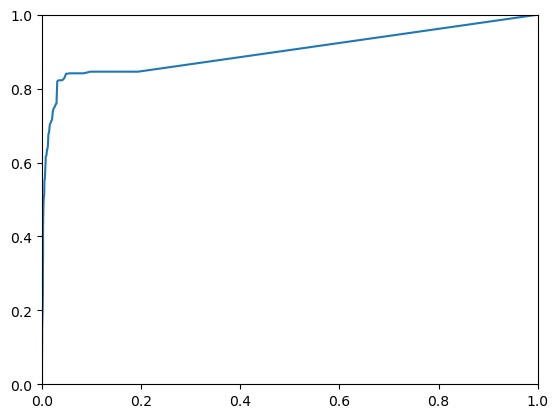

In [23]:

plt.plot(fprs,tprs)
plt.xlim([0, 1])
plt.ylim([0, 1])

In [24]:
fprs[1]

0.19409412488465083

In [25]:
tprs[1]

0.8458106098165592

In [26]:
train_dna_labels.shape

torch.Size([13007])

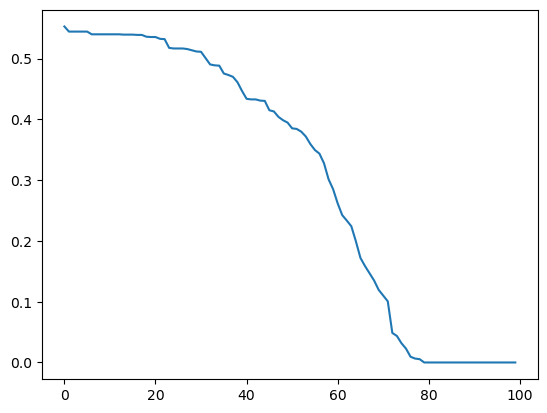

In [27]:
plt.plot(correct_genus_rate)

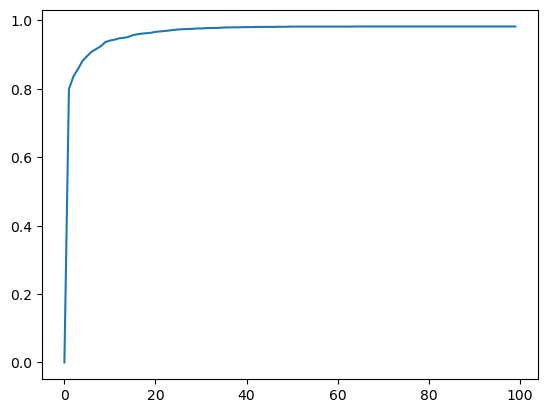

In [28]:
plt.plot(correct_species_rate)

In [35]:
chhh = 12
correct_species_rate[chhh]

0.9477083974161796

In [36]:
correct_genus_rate[chhh]

0.5399107585523054

In [33]:
train_dna_features.shape

torch.Size([10840, 3250])

In [ ]:
for i,row in enumerate(df['image_urls']):
    print(i,sep=" ")
    print(row)
    input()

0
http://v3.boldsystems.org/pics/ANICL/10ANIC_08059+1288052608.jpg


In [108]:
img2dna[list(img2dna)[38]]


'DIRTT100-14'

In [113]:
(img2dna)


{'image_dataset/Leucania_cruegeri/10ANIC_08059+1288052608.jpg': 'ANICL062-10',
 'image_dataset/Lestica_alata/BC_ZSM_HYM_24216+1440710108.jpg': 'BCHYM11106-15',
 'image_dataset/Liotryphon_punctulatus/BC-ZSM-HYM-27761-D07+1429045164.jpg': 'BCHYM7643-15',
 'image_dataset/Lesmone_formularis/06-SRNP-109430_DHJ609430+1199992320.jpg': 'BLPBC407-07',
 'image_dataset/Lesmone_formularis/07-SRNP-101378_DHJ611342+1174583648.jpg': 'BLPBE439-07',
 'image_dataset/Lesmone_formularis/07-SRNP-106954_DHJ616918+1188495614.jpg': 'BLPCC469-08',
 'image_dataset/Lesmone_formularis/07-SRNP-112250_DHJ622214+1202911152.jpg': 'BLPCI125-08',
 'image_dataset/Lesmone_formularis/07-SRNP-113574_DHJ623538+1204038314.jpg': 'BLPCJ509-08',
 'image_dataset/Lesmone_formularis/08-SRNP-108981-DHJ633045+1364926698.jpg': 'BLPDE146-09',
 'image_dataset/Lesmone_gentilis/12-SRNP-100569-DHJ667502+1344956152.JPG': 'BLPEE570-12',
 'image_dataset/Leucania_comma/IMG_9917+1238606356.JPG': 'CGUKC237-09',
 'image_dataset/Limodromus_assimi

In [15]:
X_test.shape

(9991, 5)

In [18]:
n_

12430

In [173]:
len(np.unique(list(img2dna_indices.values())))

10839

(array([1235., 1246., 1355., 1434., 1079., 1326., 1337., 1478., 1444.,
        1105.]),
 array([    0. ,  3242.3,  6484.6,  9726.9, 12969.2, 16211.5, 19453.8,
        22696.1, 25938.4, 29180.7, 32423. ]),
 <BarContainer object of 10 artists>)

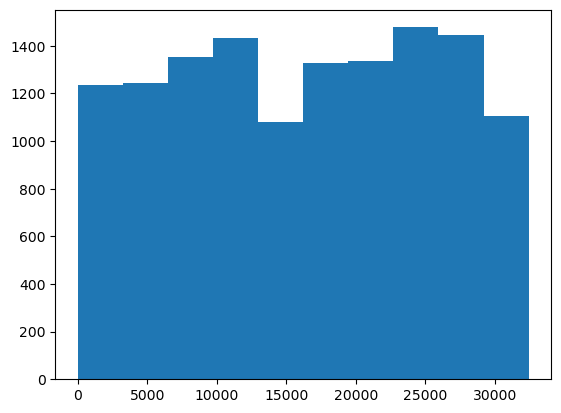

In [176]:

plt.hist(np.unique(list(img2dna_indices.keys())))